https://www.sfu.ca/~ssurjano/holder.html
https://www.sfu.ca/~ssurjano/crossit.html

In [43]:
import numpy as np
import random
import json

from typing import List, Tuple, Callable

import binary_utils as bu
import real_utils as ru
import experiments_utils as eu

In [44]:
with open('config.json', 'r') as f:
    config = json.load(f)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_function(func, x_range=(-10, 10), y_range=(-10, 10), resolution=100, title="Function Visualization"):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = func(X[i, j], Y[i, j])
    
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(121)
    contour = ax1.contourf(X, Y, Z, 50, cmap='inferno')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'{title} - Contour Plot')
    plt.colorbar(contour, ax=ax1)
    
    ax2 = fig.add_subplot(122, projection='3d')
    surface = ax2.plot_surface(X, Y, Z, cmap='inferno', 
                               linewidth=0, antialiased=True, alpha=0.8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(f'{title} - Surface Plot')
    
    plt.tight_layout()
    plt.show()

In [46]:
def cross_in_tray(x1: int, x2: int) -> int:
    term1 = np.sin(x1) * np.sin(x2)
    term2 = np.exp(abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))

    return -0.0001 * (abs(term1 * term2) + 1) ** 0.1

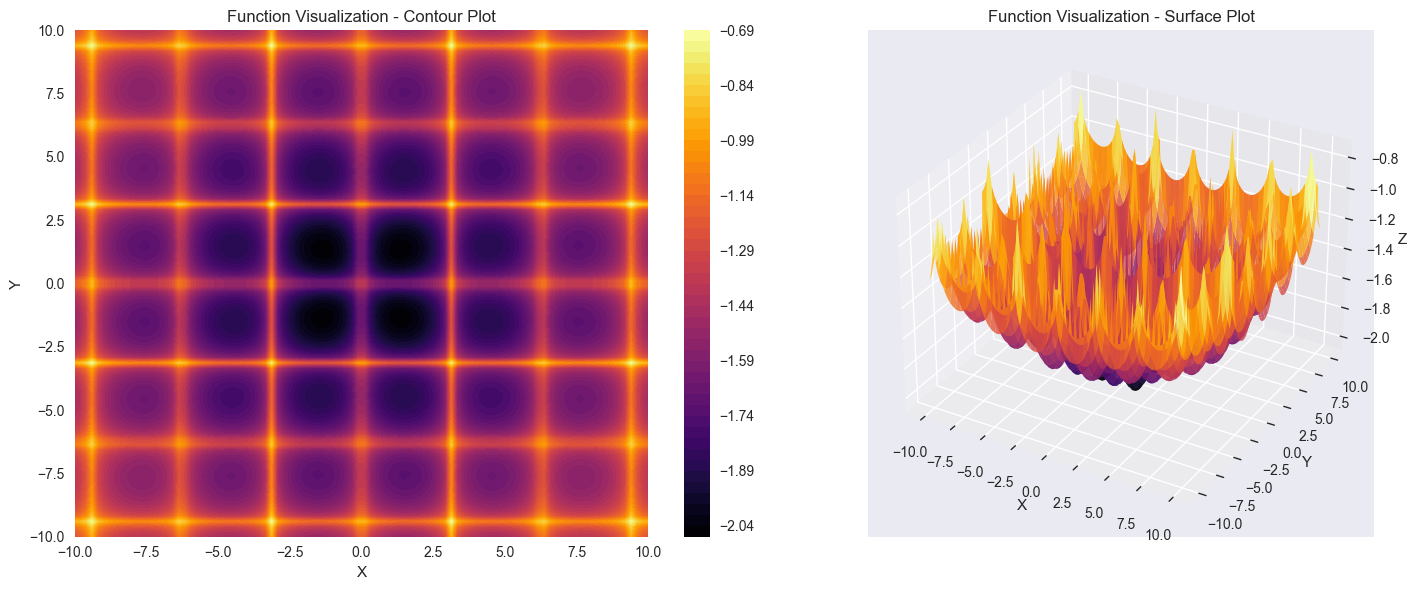

In [47]:
visualize_function(cross_in_tray)

In [48]:
def holder_table(x1: int, x2: int) -> int:
    term1 = np.sin(x1) * np.cos(x2)
    term2 = np.exp(abs(1 - (np.sqrt(x1 ** 2 + x2 ** 2)) / np.pi))

    return -1 * abs(term1 * term2)
    

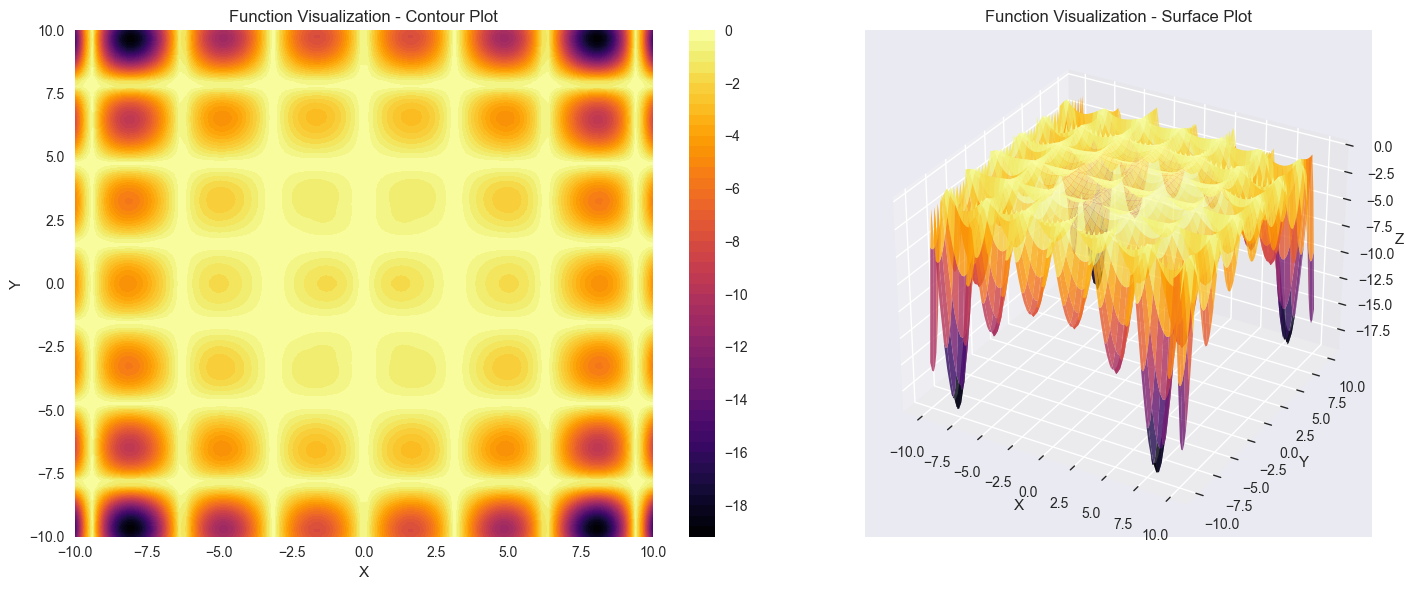

In [49]:
visualize_function(holder_table)

In [50]:
def fitness(individual: str, optimization_f: Callable) -> float:
    if isinstance(individual, str):
        x1, x2 = bu.decode(individual) 
    else:
        x1, x2 = individual
    
    return -1 * optimization_f(x1, x2)

In [51]:
def evaluate_function(individual, optimization_f: Callable) -> float:
    if isinstance(individual, str):
        x1, x2 = bu.decode(individual) 
    else:
        x1, x2 = individual
    
    return optimization_f(x1, x2)

In [52]:
def generate_initial_population(generate_f: Callable, optimization_f: Callable) -> List[dict]:
    population_size = config["population_size"]
    generation = []
    
    for _ in range(population_size):
        individual = generate_f()
        
        fitness_score = fitness(individual, optimization_f)
        function_value = evaluate_function(individual, optimization_f)
            
        generation.append({
            "genotype": individual,
            "fitness": fitness_score,
            "function_value": function_value
        })
    return generation

In [53]:
def tournament_selection(population, tournament_size=3):
    tournament = random.sample(population, tournament_size)

    return max(tournament, key=lambda ind: ind["fitness"])

In [54]:
def find_minimum(optimization_f: Callable, crossover_f: Callable, mutation_f: Callable, representation='binary'):
    if representation == 'binary':
        population = generate_initial_population(bu.generate_binary_individual, optimization_f)
    else:
        population = generate_initial_population(ru.generate_real_individual, optimization_f)
    
    best_overall = max(population, key=lambda ind: ind["fitness"])
    
    generations = config["generations"]
    population_size = config["population_size"]
    crossover_rate = config["crossover_rate"]
    
    for _ in range(generations):
        new_population = []
        
        elite = max(population, key=lambda ind: ind["fitness"])
        new_population.append(elite)
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            if random.random() < crossover_rate:
                child1_genotype, child2_genotype = crossover_f(parent1["genotype"], parent2["genotype"])
            else: 
                child1_genotype, child2_genotype = parent1["genotype"], parent2["genotype"]
                
            child1_genotype = mutation_f(child1_genotype)
            child2_genotype = mutation_f(child2_genotype)
            
            child1 = {
                "genotype": child1_genotype, 
                "fitness": fitness(child1_genotype, optimization_f),
                "function_value": evaluate_function(child1_genotype, optimization_f)
            }
            new_population.append(child1)
            
            if len(new_population) < population_size:
                child2 = {
                    "genotype": child2_genotype, 
                    "fitness": fitness(child2_genotype, optimization_f),
                    "function_value": evaluate_function(child2_genotype, optimization_f)
                }
                new_population.append(child2)
                
        population = new_population
        current_best = max(population, key=lambda ind: ind["fitness"])
        if current_best["fitness"] > best_overall["fitness"]:
            best_overall = current_best
    
    return best_overall

In [55]:
def run_all_experiments():
    functions = [cross_in_tray, holder_table]
    function_names = ['Cross-in-Tray', 'Holder Table']
    
    known_optima = {
        'Cross-in-Tray': -2.06261,
        'Holder Table': -19.2085
    }
    
    experiments = [
        ('binary', bu.one_point_crossover, bu.binary_mutation),
        ('binary', bu.two_point_crossover, bu.binary_mutation),
        ('real', ru.arithmetic_crossover, ru.real_mutation),
        ('real', ru.blx_alpha_crossover, ru.real_mutation)
    ]
    
    results = {}
    
    for func, func_name in zip(functions, function_names):
        results[func_name] = {}
        global_optimum = known_optima[func_name]
        
        for representation, crossover, mutation in experiments:
            exp_name = f"{representation}_{crossover.__name__}"
            
            function_values = []
            for _ in range(30):
                result = find_minimum(func, crossover, mutation, representation)
                function_values.append(result["function_value"])
            
            results[func_name][exp_name] = {
                'mean': np.mean(function_values),
                'std': np.std(function_values),
                'best': min(function_values),
                'global_optimum': global_optimum,
                'distance_to_optimum': min(function_values) - global_optimum
            }
    
    return results

{'mutation_rate': 0.1, 'crossover_rate': 0.8, 'population_size': 30, 'generations': 25, 'bits_per_input': 16}
       Function  Representation            Crossover      Mean Value   Std Deviation      Best Value Global minimum:          Error:
  Cross-in-Tray          Binary  One Point Crossover       -2.062067        0.000701       -2.062603       -2.062610        0.000007
  Cross-in-Tray          Binary  Two Point Crossover       -2.061764        0.001406       -2.062609       -2.062610        0.000001
  Cross-in-Tray            Real Arithmetic Crossover       -2.062611        0.000001       -2.062612       -2.062610       -0.000002
  Cross-in-Tray            Real  Blx Alpha Crossover       -2.062612        0.000000       -2.062612       -2.062610       -0.000002
   Holder Table          Binary  One Point Crossover      -19.145070        0.070274      -19.208465      -19.208500        0.000035
   Holder Table          Binary  Two Point Crossover      -19.168162        0.041144      -1

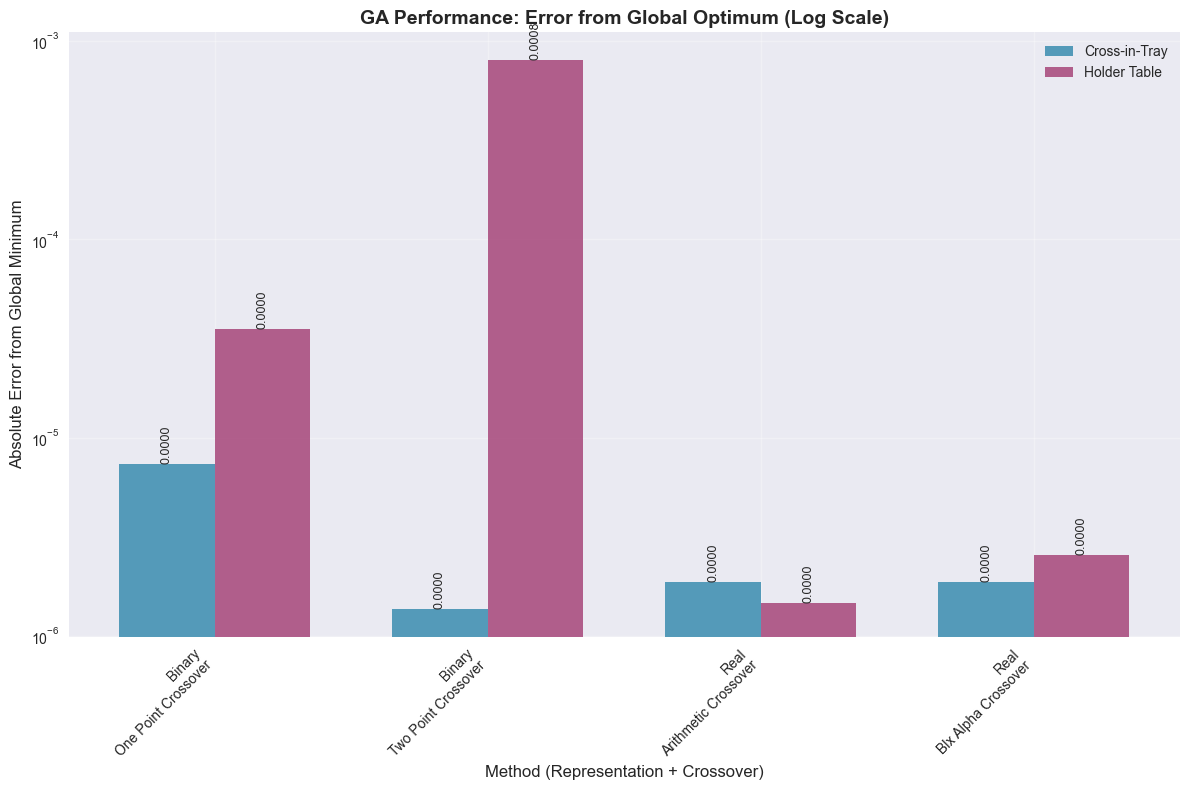


CROSS-IN-TRAY:
Best Mean Performance: binary_two_point_crossover
  Mean: -2.061764, Std: 0.001406
Worst Mean Performance: real_blx_alpha_crossover
  Mean: -2.062612, Std: 0.000000
Most Stable (Lowest Std): real_blx_alpha_crossover
  Mean: -2.062612, Std: 0.000000
Performance Improvement: 0.04%

HOLDER TABLE:
Best Mean Performance: real_arithmetic_crossover
  Mean: -16.876042, Std: 3.995449
Worst Mean Performance: real_blx_alpha_crossover
  Mean: -19.208497, Std: 0.000018
Most Stable (Lowest Std): real_blx_alpha_crossover
  Mean: -19.208497, Std: 0.000018
Performance Improvement: 12.14%


In [56]:
print(config)

results = run_all_experiments()
df = eu.visualize_all_results(results)